In [29]:
import geoopt as g
import torch
from torch.utils.data import DataLoader
import numpy as np
from datasets import load_dataset
from hierarchy_transformers import HierarchyTransformer
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from scipy.stats import pearsonr
import umap
import matplotlib.pyplot as plt
import os

by Ciprian Bangu & Daniel Dager

# Notebook 2: Going beyond the paper: A test of language understanding

As He et al. (2024) note, the question remains as to whether hyperbolic language models retain their language understanding abilities. In this notebook, we aim to answer this question by assessing the Hyperbolic and base version of the model on the STS-B dataset (Cer et al. 2017). 

The STS-B is a semantic similarity dataset that aims to assess whether language model's judgment (via cosine similarity) of the similarity of sentences matches that of humans. Thus, comparing the scores on this evaluation between the HiT and the base Language Model will give us an idea of how much, if any, language understanding is lost by the hyperbolization and retraining process.



### Dataset Loading and Formatting

In [3]:
# semantic text similarity
sts_b = load_dataset("glue", "stsb")

In [4]:
# tokenizer for the model
tokenizer_HiT = AutoTokenizer.from_pretrained("Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun")
tokenizer_allMini = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

In [5]:
# Tokenize the datasets
def process_samples(samples, tokenizer):
    # Tokenize the text via the tokenizer
    return tokenizer(samples["sentence1"], samples["sentence2"], padding=True, truncation=True, return_tensors="pt")

sts_b_HT = sts_b.map(lambda x: process_samples(x, tokenizer_HiT), batched=True)
sts_b_LM = sts_b.map(lambda x: process_samples(x, tokenizer_allMini), batched=True)

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [6]:
# Convert to PyTorch tensors
def format_to_torch(dataset, label_key): 
    dataset = dataset.remove_columns(["idx"])
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', label_key])
    return dataset

def normalize_labels(example):
	example['label'] = example['label'] / 5.0
	return example

In [7]:
sts_b_LM_formatted = format_to_torch(sts_b_LM['validation'], "label").map(normalize_labels)
sts_b_HT_formatted = format_to_torch(sts_b_HT['validation'], "label").map(normalize_labels)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [13]:
# Convert dataset to proper format
def prepare_sentence_transformer_dataset(dataset):
    return [{"sentence1": s1, "sentence2": s2, "labels": label} for s1, s2, label in zip(dataset["sentence1"], dataset["sentence2"], dataset["label"])]

# Prepare datasets
sts_b_HT_data = prepare_sentence_transformer_dataset(sts_b_HT_formatted)
sts_b_LM_data = prepare_sentence_transformer_dataset(sts_b_LM_formatted)

In [ ]:
# Load the models
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
hit_model = SentenceTransformer("Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun")
elm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")
elm_model.to(device)
hit_model.to(device)

### Model Evaluation

In [ ]:
def evaluate_model(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            sentences1 = batch["sentence1"]
            sentences2 = batch["sentence2"]
            labels = batch["labels"].numpy()  # Extract labels

            # embed the sentences 
            embeddings1 = model.encode(sentences1, convert_to_tensor=True)
            embeddings2 = model.encode(sentences2, convert_to_tensor=True)

            # get cosine sims
            similarity_scores = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

            all_predictions.extend(similarity_scores)
            all_labels.extend(labels)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)


    metric = {"pearson_correlation": pearsonr(all_predictions, all_labels)[0]}

    return metric

In [39]:
# Evaluate models
hit_results = evaluate_model(hit_model, sts_b_HT_data)
print("Hyperbolic Model Performance:")
print("STS-B:", hit_results)

euclid_results = evaluate_model(elm_model, sts_b_LM_data)
print("\nEuclidean Model Performance:")
print("STS-B:", euclid_results)


Hyperbolic Model Performance:
STS-B: {'pearson_correlation': np.float32(0.76108116)}

Euclidean Model Performance:
STS-B: {'pearson_correlation': np.float32(0.8769108)}


As we can see from the results, the retraining into a hyperbolic heirarchy transformer cause the model to loose about 10% of its score on the 0-shot STS-B benchmark. This indicates that the retraining and rearchitecting of the model has a negative impact on its overall natural language understanding. However, this trade-off might be worth it when considering the results of the euclidean model on the hierarchy task. Recall, the F1 score recorded by the base (naive) Euclidean model was 0.209; the HiT scored 0.885. Thus the Naive Euclidean model performs terribly in hierarchical domain, wheras the HiT performs mediocerly in the language understanding domain. 

### What about the fine-tuned Euclidean?

In [33]:
cwd = os.getcwd()
fine_tune_path = cwd + "/scripts/training/sft"
checkpoint_path = fine_tune_path + "/experiments/SFT-all-MiniLM-L12-v2-WordNetNoun-MixedHop-RandomNegatives/checkpoint-8802"

ft_euclidean = AutoModel.from_pretrained(checkpoint_path)
ft_euclidean_tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
ft_euclidean.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# this model doesnt have an encode method so it needs its own evlaution function... 
def evaluate_bert_model(model, tokenizer, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            sentences1 = batch["sentence1"]
            sentences2 = batch["sentence2"]
            labels = batch["labels"].numpy()  
            inputs1 = tokenizer(sentences1, padding=True, truncation=True, return_tensors="pt").to(device)
            inputs2 = tokenizer(sentences2, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)
            embeddings1 = outputs1.last_hidden_state.mean(dim=1)
            embeddings2 = outputs2.last_hidden_state.mean(dim=1)
            similarity_scores = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()
            all_predictions.extend(similarity_scores)
            all_labels.extend(labels)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    metric = {"pearson_correlation": pearsonr(all_predictions, all_labels)[0]}

    return metric

Fine-tuned Euclidean Model Performance:
STS-B: {'pearson_correlation': np.float32(0.5645594)}


In [ ]:
ft_euclid_results = evaluate_bert_model(ft_euclidean, ft_euclidean_tokenizer, sts_b_LM_data)
print("Fine-tuned Euclidean Model Performance:")
print("STS-B:", ft_euclid_results)

Fine-tuned Euclidean Model Performance:
STS-B: {'pearson_correlation': np.float32(0.5645594)}


Interestingly, the Fine-Tuned Euclidean model does worse than the HIT on the STS-B evaluation! This suggests that while one has some success when trying to reorganize the euclidean model's weights and embeddings to match the hierarchy task, this comes at the cost of greatly imparing its general semantic abilities. 

Conversely, it seems that training the hyperbolic model to do the hierarchy task allows it to retain most of its semantic abilities. This suggests that the hyperbolic embedding space is in fact much richer than the euclidean one, allowing the model to learn both hierarchical and general semantic relationships. While preliminary, this finding indicates that hyperbolic langauge models provide a good compromise between hierarchical abilities and language understanding, and could be suitable in situations where this duality is required.

### Results Summary

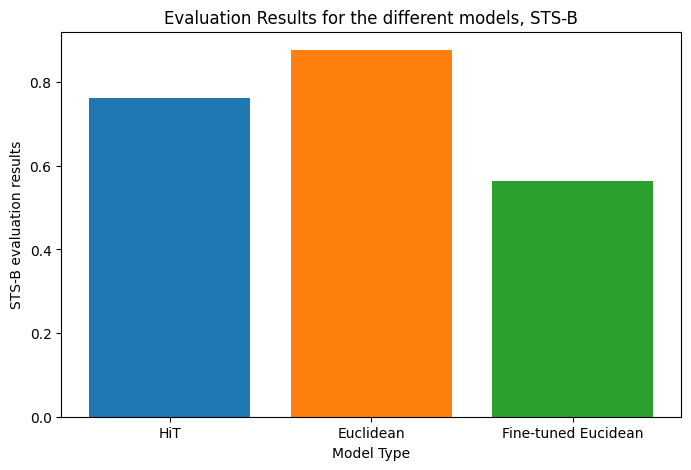

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar('HiT', hit_results['pearson_correlation'])
ax.bar("Euclidean", euclid_results['pearson_correlation'])
ax.bar('Fine-tuned Eucidean', ft_euclid_results['pearson_correlation'])
ax.set_ylabel("STS-B evaluation results")
ax.set_xlabel("Model Type")
ax.set_title("Evaluation Results for the different models, STS-B")
plt.show()

## Citations:

Cer, D., Diab, M., Agirre, E., Lopez-Gazpio, I., & Specia, L. (2017). SemEval-2017 Task 1: Semantic Textual Similarity - Multilingual and Cross-lingual Focused Evaluation. Proceedings of the 11th International Workshop on Semantic Evaluation (SemEval-2017), 1–14. https://doi.org/10.18653/v1/S17-2001

He, Y., Yuan, Z., Chen, J., & Horrocks, I. (2024). Language Models as Hierarchy Encoders (No. arXiv:2401.11374; Version 1). arXiv. https://doi.org/10.48550/arXiv.2401.11374
